## Exercise Overview
In this exercise we will play with Spark [Datasets & Dataframes](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes), some [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), and build a couple of binary classifiaction models using [Spark ML](https://spark.apache.org/docs/latest/ml-guide.html) (with some [MLlib](https://spark.apache.org/mllib/) too). 
<br><br>
The set up and approach will not be too dissimilar to the standard type of approach you might do in [Sklearn](http://scikit-learn.org/stable/index.html). Spark has matured to the stage now where for 90% of what you need to do (when analysing tabular data) should be possible with Spark dataframes, SQL, and ML libraries. This is where this exercise is mainly trying to focus.  
<br>
Feel free to adapt this exercise to play with other datasets readily availabe in the Databricks enviornment (they are listed in a cell below). 

##### Getting Started
To get started you will need to create and attach a databricks spark cluster to this notebook. This notebook was developed on a cluster created with: 
- Databricks Runtime Version 4.0 (includes Apache Spark 2.3.0, Scala 2.11)
- Python Version 3

##### Links & References

Some useful links and references of sources used in creating this exercise:

**Note**: Right click and open as new tab!
<br>
1. [Latest Spark Docs](https://spark.apache.org/docs/latest/index.html)
1. [Databricks Homepage](https://databricks.com/)
1. [Databricks Community Edition FAQ](https://databricks.com/product/faq/community-edition)
1. [Databricks Self Paced Training](https://databricks.com/training-overview/training-self-paced)
1. [Databricks Notebook Guide](https://docs.databricks.com/user-guide/notebooks/index.html)
1. [Databricks Binary Classification Tutorial](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html#binary-classification)

In [0]:
import numpy as np
import pandas as pd

#### Get Data

Here we will pull in some sample data that is already pre-loaded onto all databricks clusters.

Feel free to adapt this notebook later to play around with a different dataset if you like (all available are listed in a cell below).

In [0]:
# display datasets already in databricks
display(dbutils.fs.ls("/databricks-datasets"))

path name size dbfs:/databricks-datasets/ databricks-datasets/ 0 dbfs:/databricks-datasets/COVID/ COVID/ 0 dbfs:/databricks-datasets/README.md README.md 976 dbfs:/databricks-datasets/Rdatasets/ Rdatasets/ 0 dbfs:/databricks-datasets/SPARK_README.md SPARK_README.md 3359 dbfs:/databricks-datasets/adult/ adult/ 0 dbfs:/databricks-datasets/airlines/ airlines/ 0 dbfs:/databricks-datasets/amazon/ amazon/ 0 dbfs:/databricks-datasets/asa/ asa/ 0 dbfs:/databricks-datasets/atlas_higgs/ atlas_higgs/ 0 dbfs:/databricks-datasets/bikeSharing/ bikeSharing/ 0 dbfs:/databricks-datasets/cctvVideos/ cctvVideos/ 0 dbfs:/databricks-datasets/credit-card-fraud/ credit-card-fraud/ 0 dbfs:/databricks-datasets/cs100/ cs100/ 0 dbfs:/databricks-datasets/cs110x/ cs110x/ 0 dbfs:/databricks-datasets/cs190/ cs190/ 0 dbfs:/databricks-datasets/data.gov/ data.gov/ 0 dbfs:/databricks-datasets/definitive-guide/ definitive-guide/ 0 dbfs:/databricks-datasets/flights/ flights/ 0 dbfs:/databricks-datasets/flower_photos/ flower_photos/ 0 dbfs:/databricks-datasets/flowers/ flowers/ 0 dbfs:/databricks-datasets/genomics/ genomics/ 0 dbfs:/databricks-datasets/hail/ hail/ 0 dbfs:/databricks-datasets/iot/ iot/ 0 dbfs:/databricks-datasets/iot-stream/ iot-stream/ 0 dbfs:/databricks-datasets/learning-spark/ learning-spark/ 0 dbfs:/databricks-datasets/learning-spark-v2/ learning-spark-v2/ 0 dbfs:/databricks-datasets/lending-club-loan-stats/ lending-club-loan-stats/ 0 dbfs:/databricks-datasets/med-images/ med-images/ 0 dbfs:/databricks-datasets/mnist-digits/ mnist-digits/ 0 dbfs:/databricks-datasets/news20.binary/ news20.binary/ 0 dbfs:/databricks-datasets/nyctaxi/ nyctaxi/ 0 dbfs:/databricks-datasets/online_retail/ online_retail/ 0 dbfs:/databricks-datasets/overlap-join/ overlap-join/ 0 dbfs:/databricks-datasets/power-plant/ power-plant/ 0 dbfs:/databricks-datasets/retail-org/ retail-org/ 0 dbfs:/databricks-datasets/rwe/ rwe/ 0 dbfs:/databricks-datasets/sai-summit-2019-sf/ sai-summit-2019-sf/ 0 dbfs:/databricks-datasets/sample_logs/ sample_logs/ 0 dbfs:/databricks-datasets/samples/ samples/ 0 dbfs:/databricks-datasets/sfo_customer_survey/ sfo_customer_survey/ 0 dbfs:/databricks-datasets/sms_spam_collection/ sms_spam_collection/ 0 dbfs:/databricks-datasets/songs/ songs/ 0 dbfs:/databricks-datasets/structured-streaming/ structured-streaming/ 0 dbfs:/databricks-datasets/timeseries/ timeseries/ 0 dbfs:/databricks-datasets/tpch/ tpch/ 0 dbfs:/databricks-datasets/weather/ weather/ 0 dbfs:/databricks-datasets/wiki/ wiki/ 0 dbfs:/databricks-datasets/wikipedia-datasets/ wikipedia-datasets/ 0 dbfs:/databricks-datasets/wine-quality/ wine-quality/ 0

Lets take a look at the '**adult**' dataset on the filesystem. This is the typical US Census data you often see online in tutorials. [Here](https://archive.ics.uci.edu/ml/datasets/adult) is the same data in the UCI repository.

_As an aside: [here](https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census) this same dataset is used as a quickstart example for Google CLoud ML & Tensorflow Estimator API (in case youd be interested in playing with tensorflow on the same dataset as here)._

In [0]:
%fs ls databricks-datasets/adult/adult.data

path name size dbfs:/databricks-datasets/adult/adult.data adult.data 3974305

**Note**: Above  %fs is just some file system cell magic that is specific to databricks. More info [here](https://docs.databricks.com/user-guide/notebooks/index.html#mix-languages).

#### Spark SQL

Below we will use Spark SQL to load in the data and then register it as a Dataframe aswell. So the end result will be a Spark SQL table called _adult_ and a Spark Dataframe called _df_adult_. 
<br><br>
This is an example of the flexibility in Spark in that you could do lots of you ETL and data wrangling using either Spark SQL or Dataframes and pyspark. Most of the time it's a case of using whatever you are most comfortable with.
<br><br>
When you get more advanced then you might looking the pro's and con's of each and when you might favour one or the other (or operating direclty on RDD's), [here](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html) is a good article on the issues. For now, no need to overthink it!

In [0]:
%sql 
-- drop the table if it already exists
DROP TABLE IF EXISTS adult

In [0]:
%sql
-- create a new table in Spark SQL from the datasets already loaded in the underlying filesystem.
-- In the real world you might be pointing at a file on HDFS or a hive table etc. 
CREATE TABLE adult (
  age DOUBLE,
  workclass STRING,
  fnlwgt DOUBLE,
  education STRING,
  education_num DOUBLE,
  marital_status STRING,
  occupation STRING,
  relationship STRING,
  race STRING,
  sex STRING,
  capital_gain DOUBLE,
  capital_loss DOUBLE,
  hours_per_week DOUBLE,
  native_country STRING,
  income STRING)
USING com.databricks.spark.csv
OPTIONS (path "/databricks-datasets/adult/adult.data", header "true")

In [0]:
# look at the data
spark.sql("SELECT * FROM adult LIMIT 5").show() 

In [0]:
# this will look prettier in Databricks if you use display() instead
display(spark.sql("SELECT * FROM adult LIMIT 5"))

If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes.

In [0]:
# Lets get some summary marital status rates by occupation
result = spark.sql(
  """
  SELECT 
    occupation,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY 1
  ORDER BY n DESC
  """)
display(result)

occupation n married_rate widow_rate divorce_rate separated_rate bachelor_rate Prof-specialty 4140 0.53 0.02 0.13 0.02 0.3 Craft-repair 4099 0.64 0.01 0.11 0.03 0.21 Exec-managerial 4066 0.61 0.02 0.15 0.02 0.2 Adm-clerical 3769 0.28 0.04 0.22 0.04 0.42 Sales 3650 0.47 0.03 0.12 0.03 0.36 Other-service 3295 0.24 0.05 0.15 0.06 0.5 Machine-op-inspct 2002 0.51 0.03 0.14 0.04 0.29 ? 1843 0.36 0.08 0.1 0.04 0.42 Transport-moving 1597 0.63 0.02 0.11 0.02 0.21 Handlers-cleaners 1370 0.36 0.01 0.09 0.03 0.51 Farming-fishing 994 0.6 0.02 0.06 0.02 0.29 Tech-support 928 0.44 0.02 0.15 0.03 0.36 Protective-serv 649 0.6 0.01 0.12 0.02 0.24 Priv-house-serv 149 0.13 0.15 0.19 0.08 0.45 Armed-Forces 9 0.33 0.0 0.0 0.0 0.67

You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL for whatever reason.

In [0]:
# register the df we just made as a table for spark sql
sqlContext.registerDataFrameAsTable(result, "result")
spark.sql("SELECT * FROM result").show(5)

+----------------+----+------------+----------+------------+--------------+-------------+
 occupation| n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+----------------+----+------------+----------+------------+--------------+-------------+
 Prof-specialty|4140| 0.53| 0.02| 0.13| 0.02| 0.3|
 Craft-repair|4099| 0.64| 0.01| 0.11| 0.03| 0.21|
 Exec-managerial|4066| 0.61| 0.02| 0.15| 0.02| 0.2|
 Adm-clerical|3769| 0.28| 0.04| 0.22| 0.04| 0.42|
 Sales|3650| 0.47| 0.03| 0.12| 0.03| 0.36|
+----------------+----+------------+----------+------------+--------------+-------------+
only showing top 5 rows

#### Question 1

1. Write some spark sql to get the top 'bachelor_rate' by 'education' group?

In [0]:
### Question 1.1 Answer ###

#result = # fill in here

result_2 = spark.sql(
  """
  SELECT 
    education,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY education
  ORDER BY bachelor_rate DESC
  """)

result_2.show()

+-------------+-------------+
 education|bachelor_rate|
+-------------+-------------+
 12th| 0.54|
 11th| 0.5|
 Preschool| 0.43|
 Some-college| 0.4|
 10th| 0.39|
 Bachelors| 0.34|
 Assoc-acdm| 0.32|
 9th| 0.3|
 HS-grad| 0.29|
 5th-6th| 0.27|
 Assoc-voc| 0.26|
 Masters| 0.23|
 1st-4th| 0.23|
 Doctorate| 0.18|
 7th-8th| 0.17|
 Prof-school| 0.16|
+-------------+-------------+

#### Spark DataFrames

Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.

In [0]:
# register a df from the sql table
df_adult = spark.table("adult")
cols = df_adult.columns # this will be used much later in the notebook, ignore for now
print(cols)

['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

In [0]:
# look at df schema
df_adult.printSchema()

root
-- age: double (nullable = true)
-- workclass: string (nullable = true)
-- fnlwgt: double (nullable = true)
-- education: string (nullable = true)
-- education_num: double (nullable = true)
-- marital_status: string (nullable = true)
-- occupation: string (nullable = true)
-- relationship: string (nullable = true)
-- race: string (nullable = true)
-- sex: string (nullable = true)
-- capital_gain: double (nullable = true)
-- capital_loss: double (nullable = true)
-- hours_per_week: double (nullable = true)
-- native_country: string (nullable = true)
-- income: string (nullable = true)

In [0]:
# look at the df
display(df_adult)
#df_adult.show(5)

age workclass fnlwgt education education_num marital_status occupation relationship race sex capital_gain capital_loss hours_per_week native_country income 50.0 Self-emp-not-inc 83311.0 Bachelors 13.0 Married-civ-spouse Exec-managerial Husband White Male 0.0 0.0 13.0 United-States <=50K 38.0 Private 215646.0 HS-grad 9.0 Divorced Handlers-cleaners Not-in-family White Male 0.0 0.0 40.0 United-States <=50K 53.0 Private 234721.0 11th 7.0 Married-civ-spouse Handlers-cleaners Husband Black Male 0.0 0.0 40.0 United-States <=50K 28.0 Private 338409.0 Bachelors 13.0 Married-civ-spouse Prof-specialty Wife Black Female 0.0 0.0 40.0 Cuba <=50K 37.0 Private 284582.0 Masters 14.0 Married-civ-spouse Exec-managerial Wife White Female 0.0 0.0 40.0 United-States <=50K 49.0 Private 160187.0 9th 5.0 Married-spouse-absent Other-service Not-in-family Black Female 0.0 0.0 16.0 Jamaica <=50K 52.0 Self-emp-not-inc 209642.0 HS-grad 9.0 Married-civ-spouse Exec-managerial Husband White Male 0.0 0.0 45.0 United-States >50K 31.0 Private 45781.0 Masters 14.0 Never-married Prof-specialty Not-in-family White Female 14084.0 0.0 50.0 United-States >50K 42.0 Private 159449.0 Bachelors 13.0 Married-civ-spouse Exec-managerial Husband White Male 5178.0 0.0 40.0 United-States >50K 37.0 Private 280464.0 Some-college 10.0 Married-civ-spouse Exec-managerial Husband Black Male 0.0 0.0 80.0 United-States >50K 30.0 State-gov 141297.0 Bachelors 13.0 Married-civ-spouse Prof-specialty Husband Asian-Pac-Islander Male 0.0 0.0 40.0 India >50K 23.0 Private 122272.0 Bachelors 13.0 Never-married Adm-clerical Own-child White Female 0.0 0.0 30.0 United-States <=50K 32.0 Private 205019.0 Assoc-acdm 12.0 Never-married Sales Not-in-family Black Male 0.0 0.0 50.0 United-States <=50K 40.0 Private 121772.0 Assoc-voc 11.0 Married-civ-spouse Craft-repair Husband Asian-Pac-Islander Male 0.0 0.0 40.0 ? >50K 34.0 Private 245487.0 7th-8th 4.0 Married-civ-spouse Transport-moving Husband Amer-Indian-Eskimo Male 0.0 0.0 45.0 Mexico <=50K 25.0 Self-emp-not-inc 176756.0 HS-grad 9.0 Never-married Farming-fishing Own-child White Male 0.0 0.0 35.0 United-States <=50K 32.0 Private 186824.0 HS-grad 9.0 Never-married Machine-op-inspct Unmarried White Male 0.0 0.0 40.0 United-States <=50K 38.0 Private 28887.0 11th 7.0 Married-civ-spouse Sales Husband White Male 0.0 0.0 50.0 United-States <=50K 43.0 Self-emp-not-inc 292175.0 Masters 14.0 Divorced Exec-managerial Unmarried White Female 0.0 0.0 45.0 United-States >50K 40.0 Private 193524.0 Doctorate 16.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 60.0 United-States >50K 54.0 Private 302146.0 HS-grad 9.0 Separated Other-service Unmarried Black Female 0.0 0.0 20.0 United-States <=50K 35.0 Federal-gov 76845.0 9th 5.0 Married-civ-spouse Farming-fishing Husband Black Male 0.0 0.0 40.0 United-States <=50K 43.0 Private 117037.0 11th 7.0 Married-civ-spouse Transport-moving Husband White Male 0.0 2042.0 40.0 United-States <=50K 59.0 Private 109015.0 HS-grad 9.0 Divorced Tech-support Unmarried White Female 0.0 0.0 40.0 United-States <=50K 56.0 Local-gov 216851.0 Bachelors 13.0 Married-civ-spouse Tech-support Husband White Male 0.0 0.0 40.0 United-States >50K 19.0 Private 168294.0 HS-grad 9.0 Never-married Craft-repair Own-child White Male 0.0 0.0 40.0 United-States <=50K 54.0 ? 180211.0 Some-college 10.0 Married-civ-spouse ? Husband Asian-Pac-Islander Male 0.0 0.0 60.0 South >50K 39.0 Private 367260.0 HS-grad 9.0 Divorced Exec-managerial Not-in-family White Male 0.0 0.0 80.0 United-States <=50K 49.0 Private 193366.0 HS-grad 9.0 Married-civ-spouse Craft-repair Husband White Male 0.0 0.0 40.0 United-States <=50K 23.0 Local-gov 190709.0 Assoc-acdm 12.0 Never-married Protective-serv Not-in-family White Male 0.0 0.0 52.0 United-States <=50K 20.0 Private 266015.0 Some-college 10.0 Never-married Sales Own-child Black Male 0.0 0.0 44.0 United-States <=50K 45.0 Private 386940.0 Bachelors 13.0 Divorced Exec-managerial Own-child White Male 0.0 1408.0 40.0 United

Below we will do a similar calculation to what we did above but using the DataFrames API   
(break down individual steps)

In [0]:
# import what we will need
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['occupation'], 
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
df_result = df_result.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
df_result = df_result.orderBy(desc('divorced_rate'))
# show results
df_result.show(5)

+----------------+-------------+
 occupation|divorced_rate|
+----------------+-------------+
 Adm-clerical| 0.22|
 Priv-house-serv| 0.19|
 Tech-support| 0.15|
 Exec-managerial| 0.15|
 Other-service| 0.15|
+----------------+-------------+
only showing top 5 rows

As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.<br><br>But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.

#### Question 2
1. Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations?

In [0]:
### Question 2.1 Answer ###

# wrangle the data a bit
#df_result = # fill in here

# wrangle the data a bit
df_result_2 = df_adult.select(
  df_adult['education'], 
  when( col('marital_status').contains('Never-mar'), 1 ).otherwise(0).alias('is_bachelor')
)
# do grouping (and a round)
df_result_2 = df_result_2.groupBy('education').agg(round(mean('is_bachelor'),2).alias('bachelor_rate'))
# do ordering
df_result_2 = df_result_2.orderBy('bachelor_rate', ascending=False)
# show results
#display(df_result_2)


df_result_2.show(1)

+---------+-------------+
education|bachelor_rate|
+---------+-------------+
 12th| 0.54|
+---------+-------------+
only showing top 1 row

#### Explore & Visualize Data

It's very easy to [collect()](https://spark.apache.org/docs/latest/rdd-programming-guide.html#printing-elements-of-an-rdd) your Spark DataFrame data into a Pandas df and then continue to analyse or plot as you might normally.
<br><br>
Obviously if you try to collect() a huge DataFrame then you will run into issues, so usually you would only collect aggregated or sampled data into a Pandas df.

In [0]:
import pandas as pd

# do some analysis
result = spark.sql(
  """
  SELECT 
    occupation,
    AVG(IF(income = ' >50K',1,0)) as plus_50k
  FROM 
    adult 
  GROUP BY 1
  ORDER BY 2 DESC
  """)

print(result.schema)
display(result)
result.schema.names

StructType(List(StructField(occupation,StringType,true),StructField(plus_50k,DoubleType,true)))

occupation plus_50k Exec-managerial 0.4840137727496311 Prof-specialty 0.44903381642512075 Protective-serv 0.325115562403698 Tech-support 0.30495689655172414 Sales 0.2693150684931507 Craft-repair 0.22664064405952672 Transport-moving 0.20037570444583594 Adm-clerical 0.13451843990448395 Machine-op-inspct 0.12487512487512488 Farming-fishing 0.11569416498993963 Armed-Forces 0.1111111111111111 ? 0.10363537710255019 Handlers-cleaners 0.06277372262773723 Other-service 0.04157814871016692 Priv-house-serv 0.006711409395973154

Out[11]: ['occupation', 'plus_50k']

In [0]:
# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

# look at df
print(df_pandas.head())

occupation plus_50k
0 Exec-managerial 0.484014
1 Prof-specialty 0.449034
2 Protective-serv 0.325116
3 Tech-support 0.304957
4 Sales 0.269315

In [0]:
print(df_pandas.describe())

plus_50k
count 15.000000
mean 0.197357
std 0.143993
min 0.006711
25% 0.107373
50% 0.134518
75% 0.287136
max 0.484014

In [0]:
print(df_pandas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 occupation 15 non-null object 
 1 plus_50k 15 non-null float64
dtypes: float64(1), object(1)
memory usage: 368.0+ bytes
None

Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity we are going to use the plotting functionality built into pandas (you could make this a pretty as you want).

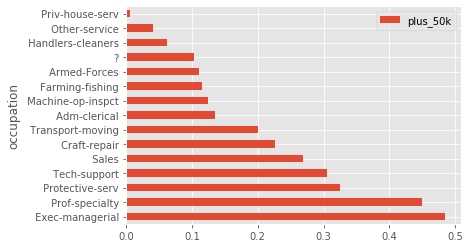

In [0]:
import matplotlib.pyplot as plt

# i like ggplot style
plt.style.use('ggplot')

# get simple plot on the pandas data
myplot = df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

# display the plot (note - display() is a databricks function - 
# more info on plotting in Databricks is here: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html)
display(myplot.figure)

You can also easily get summary stats on a Spark DataFrame like below. [Here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html) is a nice blog post that has more examples.<br><br>So this is an example of why you might want to move from Spark SQL into DataFrames API as being able to just call describe() on the Spark DF is easier then trying to do the equivilant in Spark SQL.

In [0]:
# describe df
#df_adult.select(df_adult['age'],df_adult['education_num']).describe().show()
df_adult.select('age', 'education_num').describe().show()

+-------+------------------+------------------+
summary| age| education_num|
+-------+------------------+------------------+
 count| 32560| 32560|
 mean|38.581633906633904| 10.08058968058968|
 stddev|13.640641827464002|2.5727089681052058|
 min| 17.0| 1.0|
 max| 90.0| 16.0|
+-------+------------------+------------------+

### ML Pipeline - Logistic Regression vs Random Forest

Below we will create two [Spark ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

**Note**: A lot of the code below is adapted from [this example](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html).

###### Investigate categorical columns.

In [0]:
df_adult.printSchema()

root
-- age: double (nullable = true)
-- workclass: string (nullable = true)
-- fnlwgt: double (nullable = true)
-- education: string (nullable = true)
-- education_num: double (nullable = true)
-- marital_status: string (nullable = true)
-- occupation: string (nullable = true)
-- relationship: string (nullable = true)
-- race: string (nullable = true)
-- sex: string (nullable = true)
-- capital_gain: double (nullable = true)
-- capital_loss: double (nullable = true)
-- hours_per_week: double (nullable = true)
-- native_country: string (nullable = true)
-- income: string (nullable = true)

In [0]:
categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

for col in categoricalColumns + ['income']:
  df_adult.select(col).distinct().show()

+-----------------+
 workclass|
+-----------------+
 State-gov|
 Federal-gov|
 Self-emp-not-inc|
 Local-gov|
 Private|
 ?|
 Self-emp-inc|
 Without-pay|
 Never-worked|
+-----------------+

+-------------+
 education|
+-------------+
 Prof-school|
 10th|
 7th-8th|
 5th-6th|
 Assoc-acdm|
 Assoc-voc|
 Masters|
 12th|
 Preschool|
 9th|
 Bachelors|
 Doctorate|
 HS-grad|
 11th|
 Some-college|
 1st-4th|
+-------------+

+--------------------+
 marital_status|
+--------------------+
 Widowed|
 Married-spouse-a...|
 Married-AF-spouse|
 Married-civ-spouse|
 Divorced|
 Never-married|
 Separated|
+--------------------+

+------------------+
 occupation|
+------------------+
 Farming-fishing|
 Handlers-cleaners|
 Prof-specialty|
 Adm-clerical|
 Exec-managerial|
 Craft-repair|
 Sales|
 ?|
 Tech-support|
 Transport-moving|
 Protective-serv|
 Armed-Forces|
 Machine-op-inspct|
 Other-service|
 Priv-house-serv|
+------------------+

+---------------+
 relationship|
+---------------+
 Husband|
 Own-child|
 Not-in-family|
 Other-relative|
 Wife|
 Unmarried|
+---------------+

+-------------------+
 race|
+-------------------+
 Asian-Pac-Islander|
 Black|
 Other|
 White|
 Amer-Indian-Eskimo|
+-------------------+

+-------+
 sex|
+-------+
 Male|
 Female|
+-------+

+--------------+
native_country|
+--------------+
 Cuba|
 Iran|
 United-States|
 South|
 Canada|
 Cambodia|
 Laos|
 Germany|
 Ecuador|
 Philippines|
 Honduras|
 Jamaica|
 England|
 India|
 Puerto-Rico|
 Italy|
 ?|
 Poland|
 Thailand|
 Columbia|
+--------------+
only showing top 20 rows

+------+
income|
+------+
 >50K|
 <=50K|
+------+

###### Define pre-processing for categorical columns.

In [0]:
from pyspark.ml import Pipeline
#from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [0]:
print(stages)
print(len(stages))

[StringIndexer_b1d2f79565dd, OneHotEncoder_87d9aabc384a, StringIndexer_5a8549ea22e1, OneHotEncoder_a9ceb44286af, StringIndexer_b8bfccb8e0da, OneHotEncoder_21f8e755e161, StringIndexer_039af6abc2c5, OneHotEncoder_23c2daf79498, StringIndexer_8d51bef5376c, OneHotEncoder_4e7ff7a0de8c, StringIndexer_eb0f28195421, OneHotEncoder_188bca557cd9, StringIndexer_78b98bb22d08, OneHotEncoder_4a02228aff6c, StringIndexer_7d81c8976d4a, OneHotEncoder_a9c031e7c8f7]
16

In [0]:
for index in range(len(stages)):
  #print('index = ', index)
  
  if (str(type(stages[index])).find('StringIndexer') != -1):
    print(stages[index].getInputCol(), stages[index].getOutputCol())
  
  if (str(type(stages[index])).find('OneHotEncoder') != -1):
    print(stages[index].getInputCols(), stages[index].getOutputCols())

workclass workclassIndex
['workclassIndex'] ['workclassclassVec']
education educationIndex
['educationIndex'] ['educationclassVec']
marital_status marital_statusIndex
['marital_statusIndex'] ['marital_statusclassVec']
occupation occupationIndex
['occupationIndex'] ['occupationclassVec']
relationship relationshipIndex
['relationshipIndex'] ['relationshipclassVec']
race raceIndex
['raceIndex'] ['raceclassVec']
sex sexIndex
['sexIndex'] ['sexclassVec']
native_country native_countryIndex
['native_countryIndex'] ['native_countryclassVec']

###### Define pre-processing for target column.

In [0]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

###### Define pipeline for pre-processing

In [0]:
# understand feature columns lists
categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

[c + "classVec" for c in categoricalColumns] + numericCols

Out[23]: ['workclassclassVec',
 'educationclassVec',
 'marital_statusclassVec',
 'occupationclassVec',
 'relationshipclassVec',
 'raceclassVec',
 'sexclassVec',
 'native_countryclassVec',
 'age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [0]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [0]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
#pipelineModel = pipeline.fit(df_adult)
#dataset = pipelineModel.transform(df_adult)
# Keep relevant columns
#selectedcols = ["label", "features"] + cols
#dataset = dataset.select(selectedcols)
#display(dataset)

###### Execute pipeline.

In [0]:
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(df_adult)
dataset = pipelineModel.transform(df_adult)

In [0]:
display(dataset.select('workclass', 'workclassIndex', 'workclassclassVec'))

workclass workclassIndex workclassclassVec Self-emp-not-inc 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(1), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Self-emp-not-inc 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(1), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) State-gov 4.0 Map(vectorType -> sparse, length -> 8, indices -> List(4), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Self-emp-not-inc 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(1), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Self-emp-not-inc 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(1), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Federal-gov 6.0 Map(vectorType -> sparse, length -> 8, indices -> List(6), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Local-gov 2.0 Map(vectorType -> sparse, length -> 8, indices -> List(2), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) ? 3.0 Map(vectorType -> sparse, length -> 8, indices -> List(3), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Local-gov 2.0 Map(vectorType -> sparse, length -> 8, indices -> List(2), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Federal-gov 6.0 Map(vectorType -> sparse, length -> 8, indices -> List(6), values -> List(1.0)) State-gov 4.0 Map(vectorType -> sparse, length -> 8, indices -> List(4), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Self-emp-not-inc 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(1), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Self-emp-not-inc 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(1), values -> List(1.0)) Private 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0)) Private 0.0 Map(vectorType ->

In [0]:
display(dataset.select('marital_status', 'marital_statusIndex', 'marital_statusclassVec'))

marital_status marital_statusIndex marital_statusclassVec Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Divorced 2.0 Map(vectorType -> sparse, length -> 6, indices -> List(2), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Married-spouse-absent 5.0 Map(vectorType -> sparse, length -> 6, indices -> List(5), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Never-married 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Never-married 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0)) Never-married 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Never-married 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0)) Never-married 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Divorced 2.0 Map(vectorType -> sparse, length -> 6, indices -> List(2), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Separated 3.0 Map(vectorType -> sparse, length -> 6, indices -> List(3), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Divorced 2.0 Map(vectorType -> sparse, length -> 6, indices -> List(2), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Never-married 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Divorced 2.0 Map(vectorType -> sparse, length -> 6, indices -> List(2), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Never-married 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0)) Never-married 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0)) Divorced 2.0 Map(vectorType -> sparse, length -> 6, indices -> List(2), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Never-married 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0)) Never-married 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0)) Married-AF-spouse 6.0 Map(vectorType -> sparse, length -> 6, indices -> List(), values -> List()) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0)) Married-civ-spouse 0.0 Map(vectorTyp

In [0]:
display(dataset.select('features'))

features Map(vectorType -> sparse, length -> 100, indices -> List(1, 10, 23, 31, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50.0, 83311.0, 13.0, 13.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 25, 38, 44, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 38.0, 215646.0, 9.0, 40.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 13, 23, 38, 43, 49, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53.0, 234721.0, 7.0, 40.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 10, 23, 29, 47, 49, 62, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 28.0, 338409.0, 13.0, 40.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 11, 23, 31, 47, 48, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 37.0, 284582.0, 14.0, 40.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 18, 28, 34, 44, 49, 64, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 49.0, 160187.0, 5.0, 16.0)) Map(vectorType -> sparse, length -> 100, indices -> List(1, 8, 23, 31, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52.0, 209642.0, 9.0, 45.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 11, 24, 29, 44, 48, 53, 94, 95, 96, 97, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31.0, 45781.0, 14.0, 14084.0, 50.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 10, 23, 31, 43, 48, 52, 53, 94, 95, 96, 97, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 42.0, 159449.0, 13.0, 5178.0, 40.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 9, 23, 31, 43, 49, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 37.0, 280464.0, 10.0, 80.0)) Map(vectorType -> sparse, length -> 100, indices -> List(4, 10, 23, 29, 43, 50, 52, 61, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 30.0, 141297.0, 13.0, 40.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 10, 24, 32, 45, 48, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23.0, 122272.0, 13.0, 30.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 14, 24, 33, 44, 49, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32.0, 205019.0, 12.0, 50.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 12, 23, 30, 43, 50, 52, 55, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 40.0, 121772.0, 11.0, 40.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 16, 23, 37, 43, 51, 52, 54, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34.0, 245487.0, 4.0, 45.0)) Map(vectorType -> sparse, length -> 100, indices -> List(1, 8, 24, 39, 45, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 25.0, 176756.0, 9.0, 35.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 24, 35, 46, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32.0, 186824.0, 9.0, 40.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 13, 23, 33, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 38.0, 28887.0, 7.0, 50.0)) Map(vectorType -> sparse, length -> 100, indices -> List(1, 11, 25, 31, 46, 48, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 43.0, 292175.0, 14.0, 45.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 20, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 40.0, 193524.0, 16.0, 60.0)) Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 26, 34, 46, 49, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 54.0, 302146.0, 9.0, 20.0)) Map(vectorType -> sparse, length -> 100, indices -> List(6, 18, 23, 39, 43, 49

###### Select columns needed for modeling.

In [0]:
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset_modeling = dataset.select(selectedcols)
display(dataset_modeling)

label features age workclass fnlwgt education education_num marital_status occupation relationship race sex capital_gain capital_loss hours_per_week native_country income 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(1, 10, 23, 31, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50.0, 83311.0, 13.0, 13.0)) 50.0 Self-emp-not-inc 83311.0 Bachelors 13.0 Married-civ-spouse Exec-managerial Husband White Male 0.0 0.0 13.0 United-States <=50K 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 25, 38, 44, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 38.0, 215646.0, 9.0, 40.0)) 38.0 Private 215646.0 HS-grad 9.0 Divorced Handlers-cleaners Not-in-family White Male 0.0 0.0 40.0 United-States <=50K 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 13, 23, 38, 43, 49, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53.0, 234721.0, 7.0, 40.0)) 53.0 Private 234721.0 11th 7.0 Married-civ-spouse Handlers-cleaners Husband Black Male 0.0 0.0 40.0 United-States <=50K 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 10, 23, 29, 47, 49, 62, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 28.0, 338409.0, 13.0, 40.0)) 28.0 Private 338409.0 Bachelors 13.0 Married-civ-spouse Prof-specialty Wife Black Female 0.0 0.0 40.0 Cuba <=50K 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 11, 23, 31, 47, 48, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 37.0, 284582.0, 14.0, 40.0)) 37.0 Private 284582.0 Masters 14.0 Married-civ-spouse Exec-managerial Wife White Female 0.0 0.0 40.0 United-States <=50K 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 18, 28, 34, 44, 49, 64, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 49.0, 160187.0, 5.0, 16.0)) 49.0 Private 160187.0 9th 5.0 Married-spouse-absent Other-service Not-in-family Black Female 0.0 0.0 16.0 Jamaica <=50K 1.0 Map(vectorType -> sparse, length -> 100, indices -> List(1, 8, 23, 31, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52.0, 209642.0, 9.0, 45.0)) 52.0 Self-emp-not-inc 209642.0 HS-grad 9.0 Married-civ-spouse Exec-managerial Husband White Male 0.0 0.0 45.0 United-States >50K 1.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 11, 24, 29, 44, 48, 53, 94, 95, 96, 97, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31.0, 45781.0, 14.0, 14084.0, 50.0)) 31.0 Private 45781.0 Masters 14.0 Never-married Prof-specialty Not-in-family White Female 14084.0 0.0 50.0 United-States >50K 1.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 10, 23, 31, 43, 48, 52, 53, 94, 95, 96, 97, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 42.0, 159449.0, 13.0, 5178.0, 40.0)) 42.0 Private 159449.0 Bachelors 13.0 Married-civ-spouse Exec-managerial Husband White Male 5178.0 0.0 40.0 United-States >50K 1.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 9, 23, 31, 43, 49, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 37.0, 280464.0, 10.0, 80.0)) 37.0 Private 280464.0 Some-college 10.0 Married-civ-spouse Exec-managerial Husband Black Male 0.0 0.0 80.0 United-States >50K 1.0 Map(vectorType -> sparse, length -> 100, indices -> List(4, 10, 23, 29, 43, 50, 52, 61, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 30.0, 141297.0, 13.0, 40.0)) 30.0 State-gov 141297.0 Bachelors 13.0 Married-civ-spouse Prof-specialty Husband Asian-Pac-Islander Male 0.0 0.0 40.0 India >50K 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 10, 24, 32, 45, 48, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23.0, 122272.0, 13.0, 30.0)) 23.0 Private 122272.0 Bachelors 13.0 Never-married Adm-clerical Own-child White Female 0.0 0.0 30.0 United-States <=50K 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(

###### Train-test split.

In [0]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset_modeling.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

22831
9729

###### understand averaging

In [0]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0] 

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.2398931277648811

In [0]:
temp_avg = trainingData.select(avg(testData['label']))

In [0]:
temp_avg.show()

+------------------+
 avg(label)|
+------------------+
0.2398931277648811|
+------------------+

In [0]:
print(type(temp_avg.collect()))
print(temp_avg.collect())

print(type(temp_avg.collect()[0]))
print(temp_avg.collect()[0])

print(type(temp_avg.collect()[0][0]))
print(temp_avg.collect()[0][0])

<class 'list'>
[Row(avg(label)=0.2398931277648811)]
<class 'pyspark.sql.types.Row'>
Row(avg(label)=0.2398931277648811)
<class 'float'>
0.2398931277648811

#### Logistic Regression - Train

In [0]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

###### Investigate results.

In [0]:
# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary
print(lrTrainingSummary)
lrTrainingSummary.accuracy

In [0]:
display(lrTrainingSummary.fMeasureByThreshold)

In [0]:
# Find the best model threshold if you would like to use that instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

print(maxFMeasure)
print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

#### GBM - Train

#### Question 3: GBTClassifier
1. Train a GBTClassifier on the training data, call the trained model 'gbModel'

In [0]:
### Question 3.1 Answer ###

# Create initial LogisticRegression model
#gb = # fill in here

# Train model with Training Data
#gbModel = # fill in here

from pyspark.ml.classification import GBTClassifier

gb = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

gbModel = gb.fit(trainingData)

In [0]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto' (default: all)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label, current: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5)
maxIter: max number of iterations (>= 0). (default: 20, current: 10)
maxMemoryInMB: Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size. (default: 256)
minInfoGain: Minimum information gain for a split to be considered at a tree node. (default: 0.0)
minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1. (default: 1)
minWeightFractionPerNode: Minimum fraction of the weighted sample count that each child must have after split. If a split causes the fraction of the total weight in the left or right child to be less than minWeightFractionPerNode, the split will be discarded as invalid. Should be in interval [0.0, 0.5). (default: 0.0)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
seed: random seed. (default: 3504127614838123891)
stepSize: Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator. (default: 0.1)
subsamplingRate: Fraction of the training data used for learning each decision tree, in range (0, 1]. (default: 1.0)
thresholds: Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The class with largest value p/t is predicted, where p is the original probability of that class and t is the class's threshold. (undefined)
validationIndicatorCol: name of the column that indicates whether each row is for training or for vali

#### Logistic Regression - Predict

In [0]:
print('specified threshold for positive = ', training_data_positive_rate)

# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
display(lrPredictions.select("label", "prediction", "probability"))
#display(lrPredictions)

specified threshold for positive = 0.2398931277648811

label prediction probability 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.15558714514333483, 0.8444128548566652)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.6978787145962684, 0.3021212854037317)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.48936322618261907, 0.5106367738173809)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.6787721431468228, 0.32122785685317723)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.6057264047792345, 0.3942735952207656)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.606358235816831, 0.3936417641831689)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.5967673056938737, 0.40323269430612624)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.5960955533001752, 0.40390444669982484)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7633298613814152, 0.2366701386185848)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.9892175014341769, 0.010782498565823072)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.40257010840709795, 0.597429891592902)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.4582231455298943, 0.5417768544701058)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.5277742704341208, 0.4722257295658792)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.7174365311518367, 0.28256346884816325)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.623981162849402, 0.37601883715059814)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.7179503409466579, 0.28204965905334217)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.5602921715767638, 0.4397078284232362)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.4267158646520839, 0.5732841353479161)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.5294997532475718, 0.47050024675242813)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.39301221069619535, 0.6069877893038047)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.6100525819372786, 0.38994741806272143)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.6202266233793703, 0.3797733766206298)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.5678288907032483, 0.4321711092967517)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.39731504611607754, 0.6026849538839224)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.29330938251046706, 0.706690617489533)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.48139799160042107, 0.5186020083995789)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8669901583390403, 0.13300984166095972)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8374420383205943, 0.16255796167940578)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8694074334808658, 0.13059256651913423)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.812836026406552, 0.18716397359344808)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8357643472530474, 0.1642356527469527)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8194137867927298, 0.18058621320727022)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7786198518823625, 0.2213801481176375)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.7581538369096966, 0.24184616309030352)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7964996623863141, 0.203500337613686)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8049885060684678, 0.1950114939315322)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8376465374171879, 0.16235346258281216)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8124557846808271, 0.18754421531917287)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.7531627229864

In [0]:
display(lrPredictions.select("rawPrediction"))

rawPrediction Map(vectorType -> dense, length -> 2, values -> List(-1.6914355459446642, 1.6914355459446642)) Map(vectorType -> dense, length -> 2, values -> List(0.8372167822913581, -0.8372167822913581)) Map(vectorType -> dense, length -> 2, values -> List(-0.04255351543838448, 0.04255351543838448)) Map(vectorType -> dense, length -> 2, values -> List(0.7481347883864612, -0.7481347883864612)) Map(vectorType -> dense, length -> 2, values -> List(0.4293833344362098, -0.4293833344362098)) Map(vectorType -> dense, length -> 2, values -> List(0.4320296918846638, -0.4320296918846638)) Map(vectorType -> dense, length -> 2, values -> List(0.39201346416585126, -0.39201346416585126)) Map(vectorType -> dense, length -> 2, values -> List(0.3892226466273312, -0.3892226466273312)) Map(vectorType -> dense, length -> 2, values -> List(1.171022907982188, -1.171022907982188)) Map(vectorType -> dense, length -> 2, values -> List(4.518989911473904, -4.518989911473904)) Map(vectorType -> dense, length -> 2, values -> List(-0.3947676766065287, 0.3947676766065287)) Map(vectorType -> dense, length -> 2, values -> List(-0.16749792626851723, 0.16749792626851723)) Map(vectorType -> dense, length -> 2, values -> List(0.11121156230650109, -0.11121156230650109)) Map(vectorType -> dense, length -> 2, values -> List(0.9317812915547581, -0.9317812915547581)) Map(vectorType -> dense, length -> 2, values -> List(0.5064809392326519, -0.5064809392326519)) Map(vectorType -> dense, length -> 2, values -> List(0.9343172522605308, -0.9343172522605308)) Map(vectorType -> dense, length -> 2, values -> List(0.24234790259297578, -0.24234790259297578)) Map(vectorType -> dense, length -> 2, values -> List(-0.2952630976413375, 0.2952630976413375)) Map(vectorType -> dense, length -> 2, values -> List(0.1181362155585608, -0.1181362155585608)) Map(vectorType -> dense, length -> 2, values -> List(-0.4346679925285992, 0.4346679925285992)) Map(vectorType -> dense, length -> 2, values -> List(0.44753324879581846, -0.44753324879581846)) Map(vectorType -> dense, length -> 2, values -> List(0.4905102353294146, -0.4905102353294146)) Map(vectorType -> dense, length -> 2, values -> List(0.2729985284170431, -0.2729985284170431)) Map(vectorType -> dense, length -> 2, values -> List(-0.4166650626352246, 0.4166650626352246)) Map(vectorType -> dense, length -> 2, values -> List(-0.8793650061594145, 0.8793650061594145)) Map(vectorType -> dense, length -> 2, values -> List(-0.07444239248773221, 0.07444239248773221)) Map(vectorType -> dense, length -> 2, values -> List(1.874604502384488, -1.874604502384488)) Map(vectorType -> dense, length -> 2, values -> List(1.6393174278989326, -1.6393174278989326)) Map(vectorType -> dense, length -> 2, values -> List(1.8957295713471491, -1.8957295713471491)) Map(vectorType -> dense, length -> 2, values -> List(1.4685443028989982, -1.4685443028989982)) Map(vectorType -> dense, length -> 2, values -> List(1.6270443886176262, -1.6270443886176262)) Map(vectorType -> dense, length -> 2, values -> List(1.512380891205659, -1.512380891205659)) Map(vectorType -> dense, length -> 2, values -> List(1.2576415807238268, -1.2576415807238268)) Map(vectorType -> dense, length -> 2, values -> List(1.142584481807966, -1.142584481807966)) Map(vectorType -> dense, length -> 2, values -> List(1.3645590415618825, -1.3645590415618825)) Map(vectorType -> dense, length -> 2, values -> List(1.4177694990755239, -1.4177694990755239)) Map(vectorType -> dense, length -> 2, values -> List(1.640820392233499, -1.640820392233499)) Map(vectorType -> dense, length -> 2, values -> List(1.4660468612227076, -1.4660468612227076)) Map(vectorType -> dense, length -> 2, values -> List(1.1155519820277136, -1.1155519820277136)) Map(vectorType -> dense, length -> 2, values -> List(1.385762158617756, -1.385762158617756)) Map(vectorType -> dense, length -> 2, values -> List(1.3634330631298586, -1.3634330631298586)) Map(vectorType -> dense, length -> 2, values -> List(1.032753941321839, -1.032753941321839)

#### GBM - Predict

#### Question 4: predict GBM
1. Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions'.

In [0]:
### Question 4.1 Answer ###

# make predictions on test data
#gbPredictions = # fill in here

#display(gbPredictions)

gbPredictions = gbModel.transform(testData)

display(gbPredictions.select("label", "prediction", "probability"))

label prediction probability 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.23659469985283224, 0.7634053001471678)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7197308432641665, 0.2802691567358335)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.687066640032438, 0.312933359967562)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.6570799350475207, 0.3429200649524793)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.6320070138015753, 0.3679929861984247)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.6449995911035782, 0.3550004088964218)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.6449995911035782, 0.3550004088964218)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7565893860271075, 0.24341061397289254)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.6760176955378393, 0.3239823044621607)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7946905682619675, 0.2053094317380325)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.33955072034548156, 0.6604492796545185)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.6188299764361999, 0.38117002356380014)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.6328212562085651, 0.3671787437914349)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7452783964729262, 0.25472160352707385)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7452783964729262, 0.25472160352707385)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8232566778276192, 0.17674332217238076)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.4433610028534956, 0.5566389971465044)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.40143474171537863, 0.5985652582846214)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.40143474171537863, 0.5985652582846214)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.40143474171537863, 0.5985652582846214)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8224672661988315, 0.17753273380116852)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7936404986869955, 0.2063595013130045)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7610172322399117, 0.2389827677600883)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.24206662918001112, 0.7579333708199889)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.24206662918001112, 0.7579333708199889)) 0.0 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.3926682771548602, 0.6073317228451398)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8399069224698265, 0.16009307753017354)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8317080893819911, 0.16829191061800886)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8399069224698265, 0.16009307753017354)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8105944528419716, 0.18940554715802838)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8224672661988315, 0.17753273380116852)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8224672661988315, 0.17753273380116852)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8004724171869555, 0.1995275828130445)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8224672661988315, 0.17753273380116852)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8004724171869555, 0.1995275828130445)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8224672661988315, 0.17753273380116852)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8310248287779379, 0.16897517122206207)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8224672661988315, 0.17753273380116852)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.80047241718

#### Logistic Regression - Evaluate

#### Question 5: evaluate LR

1. Complete the print_performance_metrics() function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.   
   
info for `pyspark.mllib.evaluation.MulticlassMetrics`   
https://github.com/apache/spark/blob/master/examples/src/main/python/mllib/multi_class_metrics_example.py   
https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.evaluation.MulticlassMetrics

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())
  
  ### Question 5.1 Answer ###
  
  # F1
  #print("F1 = {}".format(# fill in here))
  print("F1 = {}".format(multi_metrics.fMeasure(1.0)))
  
  # Precision
  #print("Precision = {}".format(# fill in here))
  print("Precision = {}".format(multi_metrics.precision(1.0)))
  
  # Recall
  #print("Recall = {}".format(# fill in here))
  print("Recall = {}".format(multi_metrics.recall(1.0)))
  
  # FPR
  #print("FPR = {}".format(# fill in here))
  print("FPR = {}".format(multi_metrics.falsePositiveRate(1.0)))
  
  # TPR
  #print("TPR = {}".format(# fill in here))
  print("TPR = {}".format(multi_metrics.truePositiveRate(1.0)))
  
#print_performance_metrics(lrPredictions)

In [0]:
print_performance_metrics(lrPredictions)

auc = 0.8989765008735999
aupr = 0.7560532769483124
Area under PR = 0.5358042028702068
Area under ROC = 0.8154134833086935
Accuracy = 0.8014184397163121
DenseMatrix([[5805., 1560.],
 [ 372., 1992.]])
F1 = 0.6734279918864098
Precision = 0.5608108108108109
Recall = 0.8426395939086294
FPR = 0.21181262729124237
TPR = 0.8426395939086294

#### GBM - Evaluate

In [0]:
print_performance_metrics(gbPredictions)

auc = 0.9067860806416225
aupr = 0.7811867862797952
Area under PR = 0.6395496885361467
Area under ROC = 0.7432483518907165
Accuracy = 0.8465412683729058
DenseMatrix([[6954., 411.],
 [1082., 1282.]])
F1 = 0.6319940842987429
Precision = 0.757235676314235
Recall = 0.5423011844331641
FPR = 0.05580448065173116
TPR = 0.5423011844331641

### Cross Validation

For each model you can run the below comand to see its params and a brief explanation of each.   
https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression   
https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.GBTClassifier

In [0]:
print(lr.explainParams())

In [0]:
print(gb.explainParams())

#### Logisitic Regression - Param Grid

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build())

#### GBM - Param Grid

#### Question 6: GBM param grid

1. Build out a param grid for the gb model, call it 'gbParamGrid'.

In [0]:
### Question 6.1 Answer ###

# Create ParamGrid for Cross Validation
#gbParamGrid = # fill in here
gbParamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [3, 5, 7])
             .addGrid(gb.minInstancesPerNode, [1, 5])
             .addGrid(gb.featureSubsetStrategy, ['all', 'sqrt'])
             .build())

#### Logistic Regression - Perform Cross Validation
https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.BinaryClassificationEvaluator   
`BinaryClassificationEvaluator` default `metricName='areaUnderROC'`

In [0]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

###### investigate results: best model

In [0]:
# below approach to getting at the best params from the best cv model taken from:
# https://stackoverflow.com/a/46353730/1919374

# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

# can use get methods directly
print(lrCvModel.bestModel.getRegParam())
print(lrCvModel.bestModel.getElasticNetParam())
print(lrCvModel.bestModel.getMaxIter())

0.01
0.0
5
0.01
0.0
5

###### investigate results: 18 parameter combinations

In [0]:
list_metrics = lrCvModel.avgMetrics
print(list_metrics)
max_value = np.max(list_metrics)
max_index = list_metrics.index(max_value)
print('length = ', len(list_metrics), 'max = ', max_value, 'index = ', max_index)

[0.8796937904955507, 0.8883095258162993, 0.8784258923114244, 0.8820170640333793, 0.8775073786424804, 0.8793321112875137, 0.8790848230201218, 0.8811405163768067, 0.5, 0.5, 0.5, 0.5, 0.8777992705779949, 0.8812688111770002, 0.5, 0.5, 0.5, 0.5]
length = 18 max = 0.8883095258162993 index = 1

In [0]:
list_params = lrCvModel.getEstimatorParamMaps()
print(list_params)

[{Param(parent='LogisticRegression_757e4038e364', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_757e4038e364', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_757e4038e364', name='maxIter', doc='max number of iterations (>= 0).'): 2}, {Param(parent='LogisticRegression_757e4038e364', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_757e4038e364', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_757e4038e364', name='maxIter', doc='max number of iterations (>= 0).'): 5}, {Param(parent='LogisticRegression_757e4038e364', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_757e4038e364', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5, Param(parent='LogisticRegression_757e4038e364', name='maxIter', doc='max number of iterations (>= 0).'): 2}, {Param(parent='LogisticRegression_757e4038e364', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_757e4038e364', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5, Param(parent='LogisticRegression_757e4038e364', name='maxIter', doc='max number of iterations (>= 0).'): 5}, {Param(parent='LogisticRegression_757e4038e364', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_757e4038e364', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0, Param(parent='LogisticRegression_757e4038e364', name='maxIter', doc='max number of iterations (>= 0).'): 2}, {Param(parent='LogisticRegression_757e4038e364', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_757e4038e364', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0, Param(parent='LogisticRegression_757e4038e364', name='maxIter', doc='max number of iterations (>= 0).'): 5}, {Param(parent='LogisticRegression_757e4038e364', name='regParam', doc='regularization parameter (>= 0).'): 0.5, Param(parent='LogisticRegression_757e4038e364', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_757e4038e364', name='maxIter', doc='max number of iterations (>= 0).'): 2}, {Param(parent='LogisticRegression_757e4038e364', name='regParam', doc='regularization parameter (>= 0).'): 0.5, Param(parent='LogisticRegression_757e4038e364', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_757e4038e364', name='maxIter', doc='max number of iterations (>= 0).'): 5}, {Param(parent='LogisticRegression_757e4038e364', name='regParam', doc='regularization parameter (>= 0).'): 0.5, Param(parent='LogisticRegression_757e4038e364', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5, Param(parent='LogisticRegression_757e4038e364', name='maxIter', doc='max number of iterations (>= 0).'): 2}, {Param(parent='LogisticRegression_757e4038e364', name='regPa

In [0]:
print(list_params[max_index])

{Param(parent='LogisticRegression_757e4038e364', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_757e4038e364', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_757e4038e364', name='maxIter', doc='max number of iterations (>= 0).'): 5}

#### GBM - Perform Cross Validation

#### Question 7: GBM cross validation
1. Perform cross validation of params on your 'gb' model.
1. Print out the best params you found.

In [0]:
### Question 7.1 Answer ###

# Create CrossValidator
#gbCv = # fill in here

# Run cross validations
#gbCvModel = # fill in here

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

gbCv = CrossValidator(estimator=gb, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=2)

gbCvModel = gbCv.fit(trainingData)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
print(gbCvModel.avgMetrics)

[0.8982739212474178, 0.8771881085362372, 0.8979691798820704, 0.8772583253975312, 0.9027974756704661, 0.8886398875804233, 0.902822302237277, 0.8873020497763462, 0.901208813021858, 0.8925625612667636, 0.9028023695889114, 0.891523156858258]

In [0]:
### Question 7.2 Answer ###

# look at best params from the CV
#print(# fill in here)
#print(# fill in here)

print(gbCvModel.bestModel.getMaxDepth())
print(gbCvModel.bestModel.getMinInstancesPerNode())
print(gbCvModel.bestModel.getFeatureSubsetStrategy())

5
5
all

#### Logistic Regression - CV Model Predict

In [0]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

display(lrCvPredictions)

label features age workclass fnlwgt education education_num marital_status occupation relationship race sex capital_gain capital_loss hours_per_week native_country income rawPrediction probability prediction 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 98, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36.0, 370767.0, 9.0, 2377.0, 60.0)) 36.0 Private 370767.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 2377.0 60.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(-0.7777223369999664, 0.7777223369999664)) Map(vectorType -> dense, length -> 2, values -> List(0.3148109820664107, 0.6851890179335892)) 1.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32.0, 131224.0, 9.0, 40.0)) 32.0 Private 131224.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 40.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.334668515691555, -0.334668515691555)) Map(vectorType -> dense, length -> 2, values -> List(0.5828948631530984, 0.41710513684690176)) 1.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33.0, 279173.0, 9.0, 60.0)) 33.0 Private 279173.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 60.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.3469857563368546, -0.3469857563368546)) Map(vectorType -> dense, length -> 2, values -> List(0.5858864423447456, 0.41411355765525426)) 1.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39.0, 50700.0, 9.0, 40.0)) 39.0 Private 50700.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 40.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.24998881415878182, -0.24998881415878182)) Map(vectorType -> dense, length -> 2, values -> List(0.5621737476671154, 0.4378262523328846)) 1.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39.0, 181705.0, 9.0, 45.0)) 39.0 Private 181705.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 45.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.3269265091633856, -0.3269265091633856)) Map(vectorType -> dense, length -> 2, values -> List(0.5810113617989234, 0.41898863820107646)) 1.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50.0, 81548.0, 9.0, 40.0)) 50.0 Private 81548.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 40.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.23923852428817227, -0.23923852428817227)) Map(vectorType -> dense, length -> 2, values -> List(0.5595259870243149, 0.44047401297568517)) 1.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51.0, 94432.0, 9.0, 40.0)) 51.0 Private 94432.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 40.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.2460949671517072, -0.2460949671517072)) Map(vectorType -> dense, length -> 2, values -> List(0.5612151070016728, 0.43878489299832724)) 1.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60.0, 198727.0, 9.0, 30.0)) 60.0 Private 198727.0 HS-grad 9.0 Married-civ-spouse Prof

#### GBM - CV Model Predict

In [0]:
gbCvPredictions = gbCvModel.transform(testData)

display(gbCvPredictions)

label features age workclass fnlwgt education education_num marital_status occupation relationship race sex capital_gain capital_loss hours_per_week native_country income rawPrediction probability prediction 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 98, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36.0, 370767.0, 9.0, 2377.0, 60.0)) 36.0 Private 370767.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 2377.0 60.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(-0.541486971909708, 0.541486971909708)) Map(vectorType -> dense, length -> 2, values -> List(0.2529436380753962, 0.7470563619246038)) 1.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32.0, 131224.0, 9.0, 40.0)) 32.0 Private 131224.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 40.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.5391796847409543, -0.5391796847409543)) Map(vectorType -> dense, length -> 2, values -> List(0.746183383704888, 0.253816616295112)) 0.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33.0, 279173.0, 9.0, 60.0)) 33.0 Private 279173.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 60.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.38647020770172497, -0.38647020770172497)) Map(vectorType -> dense, length -> 2, values -> List(0.6841566211220896, 0.31584337887791036)) 0.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39.0, 50700.0, 9.0, 40.0)) 39.0 Private 50700.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 40.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.3102309424462223, -0.3102309424462223)) Map(vectorType -> dense, length -> 2, values -> List(0.6503235897914982, 0.3496764102085018)) 0.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39.0, 181705.0, 9.0, 45.0)) 39.0 Private 181705.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 45.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.2799150911585073, -0.2799150911585073)) Map(vectorType -> dense, length -> 2, values -> List(0.6364132468360676, 0.3635867531639324)) 0.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50.0, 81548.0, 9.0, 40.0)) 50.0 Private 81548.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 40.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.2775022452489131, -0.2775022452489131)) Map(vectorType -> dense, length -> 2, values -> List(0.6352958897494327, 0.36470411025056726)) 0.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51.0, 94432.0, 9.0, 40.0)) 51.0 Private 94432.0 HS-grad 9.0 Married-civ-spouse Prof-specialty Husband White Male 0.0 0.0 40.0 United-States <=50K Map(vectorType -> dense, length -> 2, values -> List(0.2775022452489131, -0.2775022452489131)) Map(vectorType -> dense, length -> 2, values -> List(0.6352958897494327, 0.36470411025056726)) 0.0 0.0 Map(vectorType -> sparse, length -> 100, indices -> List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60.0, 198727.0, 9.0, 30.0)) 60.0 Private 198727.0 HS-grad 9.0 Married-civ-spouse Prof-speci

#### Logistic Regression - CV Model Evaluate

In [0]:
print_performance_metrics(lrCvPredictions)

auc = 0.8831908360643915
aupr = 0.7175268236201614
/databricks/spark/python/pyspark/sql/context.py:120: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 DeprecationWarning)
Area under PR = 0.5055509217301563
Area under ROC = 0.800773051991688
Accuracy = 0.778600061671292
DenseMatrix([[5580., 1785.],
 [ 369., 1995.]])
F1 = 0.6494140625
Precision = 0.5277777777777778
Recall = 0.8439086294416244
FPR = 0.24236252545824846
TPR = 0.8439086294416244

#### GBM - CV Model Evaluate

In [0]:
print_performance_metrics(gbCvPredictions)

auc = 0.9070340580534221
aupr = 0.781643790105851
Area under PR = 0.6392699920979691
Area under ROC = 0.7440343268511722
Accuracy = 0.8466440538595951
DenseMatrix([[6950., 415.],
 [1077., 1287.]])
F1 = 0.6330545991146089
Precision = 0.7561692126909518
Recall = 0.5444162436548223
FPR = 0.05634758995247793
TPR = 0.5444162436548223

#### Logistic Regression - Model Explore

In [0]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept: -1.243963369117579

In [0]:
lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
#lrWeights = [float(w) for w in lrWeights]
lrWeightsDF = sqlContext.createDataFrame(lrWeights, ["Feature Weight"])
display(lrWeightsDF)

Feature Weight -0.20826366275085822 -0.3307606331239198 -0.15687367327624147 -0.4595652520698125 -0.27378333809834315 0.49332767917432313 0.2806627879553949 -1.175170825520413 -0.445288390988253 -0.1885008728743296 0.46817838811357915 0.7713657934249473 -0.008429629223868225 -0.6933181761913859 -0.08181910684013989 -0.6550345237640728 -0.94866086030601 1.1717555107797586 -0.7914993968155734 -0.5597606817339866 1.1614893338018455 -0.7807222515061019 -0.8012685801765225 0.6437811849359601 -0.7842068862323027 -0.39013230433163404 -0.4568332011200047 -0.2945371465858538 -0.552488886524429 0.40815900302815983 -0.20734447357923727 0.6818838470946601 -0.2727597345570436 0.09636760622755118 -0.6963385730550135 -0.49329753538029075 -0.4604118015142968 -0.26944693648422063 -0.6172545320815576 -0.7033898413252976 0.3252645237163552 0.09662823549496079 -0.6452051425092257 0.5418315026293617 -0.4057345427746382 -0.7620762555033281 -0.5400397584343587 0.7730975907468005 -0.2495262041040547 -0.3996365609680047 -0.29795744719152345 -0.4947471604884108 0.1767602563216434 -0.4028620814234746 -0.8225217903014755 -0.4323073893213162 -0.12505219501043818 0.0056988461161830315 0.1293502119244874 -0.561595357174482 -0.6393104931773804 -0.6575861536706928 -0.10461290353264246 -0.15505525563429298 -0.5935657077061055 -0.5688275359779236 -0.7301278625475087 0.1211413830833075 -0.8256016639663134 -1.0137588253780736 -0.41396360432791773 0.3074831153563001 -0.7778966198841468 -1.0117058715560157 -0.2734524334446047 -0.37276960718246926 -0.47276128989464905 -0.34675267114684966 -0.7666468826047614 -0.7377842596160056 -0.22534405243199498 -1.72341285050443 -0.4882454670679073 -0.874362955957338 -0.07727625400967876 -0.37090424459162386 -0.9195937596579623 -0.6041718219178026 -0.13418262199109912 -0.14300701578991423 -1.1317411801367907 -0.743477347132745 0.09537600392792299 -0.277883760382927 0.0031568083638231284 -7.771849757340829E-7 0.02740570193993452 4.6762792610052906E-5 4.991262721551281E-4 0.004975484548287951

### Feature Importance

#### Question 8: LR feature importance
1. Print out a table of feature_name and feature_coefficient from the Logistic Regression model.
<br><br>
Hint: Adapt the code from here: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

In [0]:
### Question 8.1 Answer ###

# from: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

# fill in here

In [0]:
from itertools import chain

lr_attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*lrCvPredictions
        .schema[lrCvModel.bestModel.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))
lr_attrs

Out[61]: [(0, 'workclassclassVec_ Private'),
 (1, 'workclassclassVec_ Self-emp-not-inc'),
 (2, 'workclassclassVec_ Local-gov'),
 (3, 'workclassclassVec_ ?'),
 (4, 'workclassclassVec_ State-gov'),
 (5, 'workclassclassVec_ Self-emp-inc'),
 (6, 'workclassclassVec_ Federal-gov'),
 (7, 'workclassclassVec_ Without-pay'),
 (8, 'educationclassVec_ HS-grad'),
 (9, 'educationclassVec_ Some-college'),
 (10, 'educationclassVec_ Bachelors'),
 (11, 'educationclassVec_ Masters'),
 (12, 'educationclassVec_ Assoc-voc'),
 (13, 'educationclassVec_ 11th'),
 (14, 'educationclassVec_ Assoc-acdm'),
 (15, 'educationclassVec_ 10th'),
 (16, 'educationclassVec_ 7th-8th'),
 (17, 'educationclassVec_ Prof-school'),
 (18, 'educationclassVec_ 9th'),
 (19, 'educationclassVec_ 12th'),
 (20, 'educationclassVec_ Doctorate'),
 (21, 'educationclassVec_ 5th-6th'),
 (22, 'educationclassVec_ 1st-4th'),
 (23, 'marital_statusclassVec_ Married-civ-spouse'),
 (24, 'marital_statusclassVec_ Never-married'),
 (25, 'marital_statusclassVec_ Divorced'),
 (26, 'marital_statusclassVec_ Separated'),
 (27, 'marital_statusclassVec_ Widowed'),
 (28, 'marital_statusclassVec_ Married-spouse-absent'),
 (29, 'occupationclassVec_ Prof-specialty'),
 (30, 'occupationclassVec_ Craft-repair'),
 (31, 'occupationclassVec_ Exec-managerial'),
 (32, 'occupationclassVec_ Adm-clerical'),
 (33, 'occupationclassVec_ Sales'),
 (34, 'occupationclassVec_ Other-service'),
 (35, 'occupationclassVec_ Machine-op-inspct'),
 (36, 'occupationclassVec_ ?'),
 (37, 'occupationclassVec_ Transport-moving'),
 (38, 'occupationclassVec_ Handlers-cleaners'),
 (39, 'occupationclassVec_ Farming-fishing'),
 (40, 'occupationclassVec_ Tech-support'),
 (41, 'occupationclassVec_ Protective-serv'),
 (42, 'occupationclassVec_ Priv-house-serv'),
 (43, 'relationshipclassVec_ Husband'),
 (44, 'relationshipclassVec_ Not-in-family'),
 (45, 'relationshipclassVec_ Own-child'),
 (46, 'relationshipclassVec_ Unmarried'),
 (47, 'relationshipclassVec_ Wife'),
 (48, 'raceclassVec_ White'),
 (49, 'raceclassVec_ Black'),
 (50, 'raceclassVec_ Asian-Pac-Islander'),
 (51, 'raceclassVec_ Amer-Indian-Eskimo'),
 (52, 'sexclassVec_ Male'),
 (53, 'native_countryclassVec_ United-States'),
 (54, 'native_countryclassVec_ Mexico'),
 (55, 'native_countryclassVec_ ?'),
 (56, 'native_countryclassVec_ Philippines'),
 (57, 'native_countryclassVec_ Germany'),
 (58, 'native_countryclassVec_ Canada'),
 (59, 'native_countryclassVec_ Puerto-Rico'),
 (60, 'native_countryclassVec_ El-Salvador'),
 (61, 'native_countryclassVec_ India'),
 (62, 'native_countryclassVec_ Cuba'),
 (63, 'native_countryclassVec_ England'),
 (64, 'native_countryclassVec_ Jamaica'),
 (65, 'native_countryclassVec_ South'),
 (66, 'native_countryclassVec_ China'),
 (67, 'native_countryclassVec_ Italy'),
 (68, 'native_countryclassVec_ Dominican-Republic'),
 (69, 'native_countryclassVec_ Vietnam'),
 (70, 'native_countryclassVec_ Guatemala'),
 (71, 'native_countryclassVec_ Japan'),
 (72, 'native_countryclassVec_ Poland'),
 (73, 'native_countryclassVec_ Columbia'),
 (74, 'native_countryclassVec_ Taiwan'),
 (75, 'native_countryclassVec_ Haiti'),
 (76, 'native_countryclassVec_ Iran'),
 (77, 'native_countryclassVec_ Portugal'),
 (78, 'native_countryclassVec_ Nicaragua'),
 (79, 'native_countryclassVec_ Peru'),
 (80, 'native_countryclassVec_ France'),
 (81, 'native_countryclassVec_ Greece'),
 (82, 'native_countryclassVec_ Ecuador'),
 (83, 'native_countryclassVec_ Ireland'),
 (84, 'native_countryclassVec_ Hong'),
 (85, 'native_countryclassVec_ Cambodia'),
 (86, 'native_countryclassVec_ Trinadad&Tobago'),
 (87, 'native_countryclassVec_ Laos'),
 (88, 'native_countryclassVec_ Thailand'),
 (89, 'native_countryclassVec_ Yugoslavia'),
 (90, 'native_countryclassVec_ Outlying-US(Guam-USVI-etc)'),
 (91, 'native_countryclassVec_ Honduras'),
 (92, 'native_countryclassVec_ Hungary'),
 (93, 'native_countryclassVec_ Scotland'),
 (94, 'age'),
 (95, 'fnlwgt'),
 (96, 'education_num'),
 (97, 'capital_gain'),
 (98, 'capital_

In [0]:
lr_features = [name for index, name in lr_attrs]
lr_features

Out[62]: ['workclassclassVec_ Private',
 'workclassclassVec_ Self-emp-not-inc',
 'workclassclassVec_ Local-gov',
 'workclassclassVec_ ?',
 'workclassclassVec_ State-gov',
 'workclassclassVec_ Self-emp-inc',
 'workclassclassVec_ Federal-gov',
 'workclassclassVec_ Without-pay',
 'educationclassVec_ HS-grad',
 'educationclassVec_ Some-college',
 'educationclassVec_ Bachelors',
 'educationclassVec_ Masters',
 'educationclassVec_ Assoc-voc',
 'educationclassVec_ 11th',
 'educationclassVec_ Assoc-acdm',
 'educationclassVec_ 10th',
 'educationclassVec_ 7th-8th',
 'educationclassVec_ Prof-school',
 'educationclassVec_ 9th',
 'educationclassVec_ 12th',
 'educationclassVec_ Doctorate',
 'educationclassVec_ 5th-6th',
 'educationclassVec_ 1st-4th',
 'marital_statusclassVec_ Married-civ-spouse',
 'marital_statusclassVec_ Never-married',
 'marital_statusclassVec_ Divorced',
 'marital_statusclassVec_ Separated',
 'marital_statusclassVec_ Widowed',
 'marital_statusclassVec_ Married-spouse-absent',
 'occupationclassVec_ Prof-specialty',
 'occupationclassVec_ Craft-repair',
 'occupationclassVec_ Exec-managerial',
 'occupationclassVec_ Adm-clerical',
 'occupationclassVec_ Sales',
 'occupationclassVec_ Other-service',
 'occupationclassVec_ Machine-op-inspct',
 'occupationclassVec_ ?',
 'occupationclassVec_ Transport-moving',
 'occupationclassVec_ Handlers-cleaners',
 'occupationclassVec_ Farming-fishing',
 'occupationclassVec_ Tech-support',
 'occupationclassVec_ Protective-serv',
 'occupationclassVec_ Priv-house-serv',
 'relationshipclassVec_ Husband',
 'relationshipclassVec_ Not-in-family',
 'relationshipclassVec_ Own-child',
 'relationshipclassVec_ Unmarried',
 'relationshipclassVec_ Wife',
 'raceclassVec_ White',
 'raceclassVec_ Black',
 'raceclassVec_ Asian-Pac-Islander',
 'raceclassVec_ Amer-Indian-Eskimo',
 'sexclassVec_ Male',
 'native_countryclassVec_ United-States',
 'native_countryclassVec_ Mexico',
 'native_countryclassVec_ ?',
 'native_countryclassVec_ Philippines',
 'native_countryclassVec_ Germany',
 'native_countryclassVec_ Canada',
 'native_countryclassVec_ Puerto-Rico',
 'native_countryclassVec_ El-Salvador',
 'native_countryclassVec_ India',
 'native_countryclassVec_ Cuba',
 'native_countryclassVec_ England',
 'native_countryclassVec_ Jamaica',
 'native_countryclassVec_ South',
 'native_countryclassVec_ China',
 'native_countryclassVec_ Italy',
 'native_countryclassVec_ Dominican-Republic',
 'native_countryclassVec_ Vietnam',
 'native_countryclassVec_ Guatemala',
 'native_countryclassVec_ Japan',
 'native_countryclassVec_ Poland',
 'native_countryclassVec_ Columbia',
 'native_countryclassVec_ Taiwan',
 'native_countryclassVec_ Haiti',
 'native_countryclassVec_ Iran',
 'native_countryclassVec_ Portugal',
 'native_countryclassVec_ Nicaragua',
 'native_countryclassVec_ Peru',
 'native_countryclassVec_ France',
 'native_countryclassVec_ Greece',
 'native_countryclassVec_ Ecuador',
 'native_countryclassVec_ Ireland',
 'native_countryclassVec_ Hong',
 'native_countryclassVec_ Cambodia',
 'native_countryclassVec_ Trinadad&Tobago',
 'native_countryclassVec_ Laos',
 'native_countryclassVec_ Thailand',
 'native_countryclassVec_ Yugoslavia',
 'native_countryclassVec_ Outlying-US(Guam-USVI-etc)',
 'native_countryclassVec_ Honduras',
 'native_countryclassVec_ Hungary',
 'native_countryclassVec_ Scotland',
 'age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [0]:
lrCvModel.bestModel.coefficients

Out[63]: DenseVector([-0.2083, -0.3308, -0.1569, -0.4596, -0.2738, 0.4933, 0.2807, -1.1752, -0.4453, -0.1885, 0.4682, 0.7714, -0.0084, -0.6933, -0.0818, -0.655, -0.9487, 1.1718, -0.7915, -0.5598, 1.1615, -0.7807, -0.8013, 0.6438, -0.7842, -0.3901, -0.4568, -0.2945, -0.5525, 0.4082, -0.2073, 0.6819, -0.2728, 0.0964, -0.6963, -0.4933, -0.4604, -0.2694, -0.6173, -0.7034, 0.3253, 0.0966, -0.6452, 0.5418, -0.4057, -0.7621, -0.54, 0.7731, -0.2495, -0.3996, -0.298, -0.4947, 0.1768, -0.4029, -0.8225, -0.4323, -0.1251, 0.0057, 0.1294, -0.5616, -0.6393, -0.6576, -0.1046, -0.1551, -0.5936, -0.5688, -0.7301, 0.1211, -0.8256, -1.0138, -0.414, 0.3075, -0.7779, -1.0117, -0.2735, -0.3728, -0.4728, -0.3468, -0.7666, -0.7378, -0.2253, -1.7234, -0.4882, -0.8744, -0.0773, -0.3709, -0.9196, -0.6042, -0.1342, -0.143, -1.1317, -0.7435, 0.0954, -0.2779, 0.0032, -0.0, 0.0274, 0.0, 0.0005, 0.005])

In [0]:
df_lr_feature_coeff = pd.DataFrame({'feature' : lr_features ,
                                     'coefficient' : lrCvModel.bestModel.coefficients},
                                    index=np.arange(0, len(lrCvModel.bestModel.coefficients))) \
                              .sort_values('coefficient', ascending=False)
display(df_lr_feature_coeff)

feature coefficient educationclassVec_ Prof-school 1.1717555107797586 educationclassVec_ Doctorate 1.1614893338018455 relationshipclassVec_ Wife 0.7730975907468005 educationclassVec_ Masters 0.7713657934249473 occupationclassVec_ Exec-managerial 0.6818838470946601 marital_statusclassVec_ Married-civ-spouse 0.6437811849359601 relationshipclassVec_ Husband 0.5418315026293617 workclassclassVec_ Self-emp-inc 0.49332767917432313 educationclassVec_ Bachelors 0.46817838811357915 occupationclassVec_ Prof-specialty 0.40815900302815983 occupationclassVec_ Tech-support 0.3252645237163552 native_countryclassVec_ Japan 0.3074831153563001 workclassclassVec_ Federal-gov 0.2806627879553949 sexclassVec_ Male 0.1767602563216434 native_countryclassVec_ Canada 0.1293502119244874 native_countryclassVec_ Italy 0.1211413830833075 occupationclassVec_ Protective-serv 0.09662823549496079 occupationclassVec_ Sales 0.09636760622755118 native_countryclassVec_ Hungary 0.09537600392792299 education_num 0.02740570193993452 native_countryclassVec_ Germany 0.0056988461161830315 hours_per_week 0.004975484548287951 age 0.0031568083638231284 capital_loss 4.991262721551281E-4 capital_gain 4.6762792610052906E-5 fnlwgt -7.771849757340829E-7 educationclassVec_ Assoc-voc -0.008429629223868225 native_countryclassVec_ Hong -0.07727625400967876 educationclassVec_ Assoc-acdm -0.08181910684013989 native_countryclassVec_ Cuba -0.10461290353264246 native_countryclassVec_ Philippines -0.12505219501043818 native_countryclassVec_ Thailand -0.13418262199109912 native_countryclassVec_ Yugoslavia -0.14300701578991423 native_countryclassVec_ England -0.15505525563429298 workclassclassVec_ Local-gov -0.15687367327624147 educationclassVec_ Some-college -0.1885008728743296 occupationclassVec_ Craft-repair -0.20734447357923727 workclassclassVec_ Private -0.20826366275085822 native_countryclassVec_ France -0.22534405243199498 raceclassVec_ White -0.2495262041040547 occupationclassVec_ Transport-moving -0.26944693648422063 occupationclassVec_ Adm-clerical -0.2727597345570436 native_countryclassVec_ Taiwan -0.2734524334446047 workclassclassVec_ State-gov -0.27378333809834315 native_countryclassVec_ Scotland -0.277883760382927 marital_statusclassVec_ Widowed -0.2945371465858538 raceclassVec_ Asian-Pac-Islander -0.29795744719152345 workclassclassVec_ Self-emp-not-inc -0.3307606331239198 native_countryclassVec_ Portugal -0.34675267114684966 native_countryclassVec_ Cambodia -0.37090424459162386 native_countryclassVec_ Haiti -0.37276960718246926 marital_statusclassVec_ Divorced -0.39013230433163404 raceclassVec_ Black -0.3996365609680047 native_countryclassVec_ United-States -0.4028620814234746 relationshipclassVec_ Not-in-family -0.4057345427746382 native_countryclassVec_ Guatemala -0.41396360432791773 native_countryclassVec_ ? -0.4323073893213162 educationclassVec_ HS-grad -0.445288390988253 marital_statusclassVec_ Separated -0.4568332011200047 workclassclassVec_ ? -0.4595652520698125 occupationclassVec_ ? -0.4604118015142968 native_countryclassVec_ Iran -0.47276128989464905 native_countryclassVec_ Ecuador -0.4882454670679073 occupationclassVec_ Machine-op-inspct -0.49329753538029075 raceclassVec_ Amer-Indian-Eskimo -0.4947471604884108 relationshipclassVec_ Unmarried -0.5400397584343587 marital_statusclassVec_ Married-spouse-absent -0.552488886524429 educationclassVec_ 12th -0.5597606817339866 native_countryclassVec_ Puerto-Rico -0.561595357174482 native_countryclassVec_ South -0.5688275359779236 native_countryclassVec_ Jamaica -0.5935657077061055 native_countryclassVec_ Laos -0.6041718219178026 occupationclassVec_ Handlers-cleaners -0.6172545320815576 native_countryclassVec_ El-Salvador -0.6393104931773804 occupationclassVec_ Priv-house-serv -0.6452051425092257 educationclassVec_ 10th -0.6550345237640728 native_countryclassVec_ India -0.6575861536706928 educationclassVec_ 11th -0.6933181761913859 occupationclassVec_ Other-service -0.6963385730550135 occupationclassVec_ Farming-fishing -0.70

#### GB feature importance

In [0]:
gb_attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*lrCvPredictions
        .schema[lrCvModel.bestModel.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))
gb_attrs

Out[65]: [(0, 'workclassclassVec_ Private'),
 (1, 'workclassclassVec_ Self-emp-not-inc'),
 (2, 'workclassclassVec_ Local-gov'),
 (3, 'workclassclassVec_ ?'),
 (4, 'workclassclassVec_ State-gov'),
 (5, 'workclassclassVec_ Self-emp-inc'),
 (6, 'workclassclassVec_ Federal-gov'),
 (7, 'workclassclassVec_ Without-pay'),
 (8, 'educationclassVec_ HS-grad'),
 (9, 'educationclassVec_ Some-college'),
 (10, 'educationclassVec_ Bachelors'),
 (11, 'educationclassVec_ Masters'),
 (12, 'educationclassVec_ Assoc-voc'),
 (13, 'educationclassVec_ 11th'),
 (14, 'educationclassVec_ Assoc-acdm'),
 (15, 'educationclassVec_ 10th'),
 (16, 'educationclassVec_ 7th-8th'),
 (17, 'educationclassVec_ Prof-school'),
 (18, 'educationclassVec_ 9th'),
 (19, 'educationclassVec_ 12th'),
 (20, 'educationclassVec_ Doctorate'),
 (21, 'educationclassVec_ 5th-6th'),
 (22, 'educationclassVec_ 1st-4th'),
 (23, 'marital_statusclassVec_ Married-civ-spouse'),
 (24, 'marital_statusclassVec_ Never-married'),
 (25, 'marital_statusclassVec_ Divorced'),
 (26, 'marital_statusclassVec_ Separated'),
 (27, 'marital_statusclassVec_ Widowed'),
 (28, 'marital_statusclassVec_ Married-spouse-absent'),
 (29, 'occupationclassVec_ Prof-specialty'),
 (30, 'occupationclassVec_ Craft-repair'),
 (31, 'occupationclassVec_ Exec-managerial'),
 (32, 'occupationclassVec_ Adm-clerical'),
 (33, 'occupationclassVec_ Sales'),
 (34, 'occupationclassVec_ Other-service'),
 (35, 'occupationclassVec_ Machine-op-inspct'),
 (36, 'occupationclassVec_ ?'),
 (37, 'occupationclassVec_ Transport-moving'),
 (38, 'occupationclassVec_ Handlers-cleaners'),
 (39, 'occupationclassVec_ Farming-fishing'),
 (40, 'occupationclassVec_ Tech-support'),
 (41, 'occupationclassVec_ Protective-serv'),
 (42, 'occupationclassVec_ Priv-house-serv'),
 (43, 'relationshipclassVec_ Husband'),
 (44, 'relationshipclassVec_ Not-in-family'),
 (45, 'relationshipclassVec_ Own-child'),
 (46, 'relationshipclassVec_ Unmarried'),
 (47, 'relationshipclassVec_ Wife'),
 (48, 'raceclassVec_ White'),
 (49, 'raceclassVec_ Black'),
 (50, 'raceclassVec_ Asian-Pac-Islander'),
 (51, 'raceclassVec_ Amer-Indian-Eskimo'),
 (52, 'sexclassVec_ Male'),
 (53, 'native_countryclassVec_ United-States'),
 (54, 'native_countryclassVec_ Mexico'),
 (55, 'native_countryclassVec_ ?'),
 (56, 'native_countryclassVec_ Philippines'),
 (57, 'native_countryclassVec_ Germany'),
 (58, 'native_countryclassVec_ Canada'),
 (59, 'native_countryclassVec_ Puerto-Rico'),
 (60, 'native_countryclassVec_ El-Salvador'),
 (61, 'native_countryclassVec_ India'),
 (62, 'native_countryclassVec_ Cuba'),
 (63, 'native_countryclassVec_ England'),
 (64, 'native_countryclassVec_ Jamaica'),
 (65, 'native_countryclassVec_ South'),
 (66, 'native_countryclassVec_ China'),
 (67, 'native_countryclassVec_ Italy'),
 (68, 'native_countryclassVec_ Dominican-Republic'),
 (69, 'native_countryclassVec_ Vietnam'),
 (70, 'native_countryclassVec_ Guatemala'),
 (71, 'native_countryclassVec_ Japan'),
 (72, 'native_countryclassVec_ Poland'),
 (73, 'native_countryclassVec_ Columbia'),
 (74, 'native_countryclassVec_ Taiwan'),
 (75, 'native_countryclassVec_ Haiti'),
 (76, 'native_countryclassVec_ Iran'),
 (77, 'native_countryclassVec_ Portugal'),
 (78, 'native_countryclassVec_ Nicaragua'),
 (79, 'native_countryclassVec_ Peru'),
 (80, 'native_countryclassVec_ France'),
 (81, 'native_countryclassVec_ Greece'),
 (82, 'native_countryclassVec_ Ecuador'),
 (83, 'native_countryclassVec_ Ireland'),
 (84, 'native_countryclassVec_ Hong'),
 (85, 'native_countryclassVec_ Cambodia'),
 (86, 'native_countryclassVec_ Trinadad&Tobago'),
 (87, 'native_countryclassVec_ Laos'),
 (88, 'native_countryclassVec_ Thailand'),
 (89, 'native_countryclassVec_ Yugoslavia'),
 (90, 'native_countryclassVec_ Outlying-US(Guam-USVI-etc)'),
 (91, 'native_countryclassVec_ Honduras'),
 (92, 'native_countryclassVec_ Hungary'),
 (93, 'native_countryclassVec_ Scotland'),
 (94, 'age'),
 (95, 'fnlwgt'),
 (96, 'education_num'),
 (97, 'capital_gain'),
 (98, 'capital_

In [0]:
gbCvModel.bestModel.featureImportances

Out[66]: SparseVector(100, {1: 0.0195, 2: 0.0009, 3: 0.0001, 5: 0.0022, 6: 0.0052, 8: 0.0012, 9: 0.0019, 10: 0.0152, 11: 0.0008, 12: 0.0002, 14: 0.0004, 17: 0.0045, 23: 0.2551, 24: 0.0014, 29: 0.0123, 31: 0.0556, 34: 0.0175, 37: 0.0006, 38: 0.0023, 39: 0.0143, 40: 0.0083, 43: 0.0028, 44: 0.002, 46: 0.001, 47: 0.0121, 48: 0.0004, 52: 0.0131, 53: 0.0029, 62: 0.0007, 94: 0.1905, 95: 0.006, 96: 0.1547, 97: 0.0869, 98: 0.0323, 99: 0.0752})

In [0]:
gbCvFeatureImportance = pd.DataFrame([(name, gbCvModel.bestModel.featureImportances[idx]) for idx, name in gb_attrs],
                                     columns=['feature_name','feature_importance'])

#print(gbCvFeatureImportance.sort_values(by=['feature_importance'],ascending =False))
display(gbCvFeatureImportance.sort_values('feature_importance', ascending=False))

feature_name feature_importance marital_statusclassVec_ Married-civ-spouse 0.25505160396664 age 0.19049049100659177 education_num 0.15470594299901305 capital_gain 0.08689363833264425 hours_per_week 0.07524945150566771 occupationclassVec_ Exec-managerial 0.055635465456609204 capital_loss 0.03225050764659699 workclassclassVec_ Self-emp-not-inc 0.019517549804256764 occupationclassVec_ Other-service 0.017466802267708026 educationclassVec_ Bachelors 0.015172658916779892 occupationclassVec_ Farming-fishing 0.014336073863284414 sexclassVec_ Male 0.013147975426954837 occupationclassVec_ Prof-specialty 0.01226905899159699 relationshipclassVec_ Wife 0.01214374543630838 occupationclassVec_ Tech-support 0.008292322990641747 fnlwgt 0.0059803828626926285 workclassclassVec_ Federal-gov 0.005171228492186379 educationclassVec_ Prof-school 0.0045322462463757264 native_countryclassVec_ United-States 0.002865547060944902 relationshipclassVec_ Husband 0.0027553923858116844 occupationclassVec_ Handlers-cleaners 0.002303857318226079 workclassclassVec_ Self-emp-inc 0.002162879489324186 relationshipclassVec_ Not-in-family 0.0020434565880570843 educationclassVec_ Some-college 0.0018797588456673604 marital_statusclassVec_ Never-married 0.0013715231738232 educationclassVec_ HS-grad 0.0012391184466142003 relationshipclassVec_ Unmarried 0.001019167644395747 workclassclassVec_ Local-gov 9.037483903779845E-4 educationclassVec_ Masters 7.531262317102073E-4 native_countryclassVec_ Cuba 6.905791274250335E-4 occupationclassVec_ Transport-moving 6.471700763615209E-4 educationclassVec_ Assoc-acdm 3.9397313263992686E-4 raceclassVec_ White 3.6264598754066164E-4 educationclassVec_ Assoc-voc 2.3325587603822487E-4 workclassclassVec_ ? 6.765401249307389E-5 native_countryclassVec_ Italy 0.0 native_countryclassVec_ Haiti 0.0 native_countryclassVec_ Dominican-Republic 0.0 native_countryclassVec_ Iran 0.0 native_countryclassVec_ Vietnam 0.0 native_countryclassVec_ Taiwan 0.0 native_countryclassVec_ Columbia 0.0 native_countryclassVec_ Poland 0.0 native_countryclassVec_ Japan 0.0 native_countryclassVec_ Guatemala 0.0 native_countryclassVec_ Ireland 0.0 native_countryclassVec_ Portugal 0.0 native_countryclassVec_ Nicaragua 0.0 native_countryclassVec_ Scotland 0.0 native_countryclassVec_ Hungary 0.0 native_countryclassVec_ Honduras 0.0 native_countryclassVec_ Outlying-US(Guam-USVI-etc) 0.0 native_countryclassVec_ Yugoslavia 0.0 native_countryclassVec_ Thailand 0.0 native_countryclassVec_ Laos 0.0 native_countryclassVec_ Trinadad&Tobago 0.0 native_countryclassVec_ Cambodia 0.0 native_countryclassVec_ Hong 0.0 native_countryclassVec_ South 0.0 native_countryclassVec_ Ecuador 0.0 native_countryclassVec_ Greece 0.0 native_countryclassVec_ France 0.0 native_countryclassVec_ Peru 0.0 native_countryclassVec_ China 0.0 workclassclassVec_ Private 0.0 native_countryclassVec_ Jamaica 0.0 educationclassVec_ Doctorate 0.0 marital_statusclassVec_ Married-spouse-absent 0.0 marital_statusclassVec_ Widowed 0.0 marital_statusclassVec_ Separated 0.0 marital_statusclassVec_ Divorced 0.0 educationclassVec_ 1st-4th 0.0 educationclassVec_ 5th-6th 0.0 educationclassVec_ 12th 0.0 occupationclassVec_ Adm-clerical 0.0 educationclassVec_ 9th 0.0 educationclassVec_ 7th-8th 0.0 educationclassVec_ 10th 0.0 educationclassVec_ 11th 0.0 workclassclassVec_ Without-pay 0.0 workclassclassVec_ State-gov 0.0 occupationclassVec_ Craft-repair 0.0 occupationclassVec_ Sales 0.0 native_countryclassVec_ England 0.0 native_countryclassVec_ ? 0.0 native_countryclassVec_ India 0.0 native_countryclassVec_ El-Salvador 0.0 native_countryclassVec_ Puerto-Rico 0.0 native_countryclassVec_ Canada 0.0 native_countryclassVec_ Germany 0.0 native_countryclassVec_ Philippines 0.0 native_countryclassVec_ Mexico 0.0 occupationclassVec_ Machine-op-inspct 0.0 raceclassVec_ Amer-Indian-Eskimo 0.0 raceclassVec_ Black 0.0 relationshipclassVec_ Own-child 0.0 occupationclassVec_ Priv-house-serv 0.0 occupationclassVec_ Protective-serv 0.0 occupa

### Question 9: Random Forest
1. Build and train a RandomForestClassifier and print out a table of feature importances from it.

https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.RandomForestClassifier

In [0]:
### Question 9.1 Answer ###

#from pyspark.ml.classification import # fill in here

#rf = # fill in here

#rfModel = # fill in here

#rfFeatureImportance = # fill in here

#print(# fill in here)

In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=59)

rfModel = rf.fit(trainingData)

In [0]:
rfModel.featureImportances

Out[69]: SparseVector(100, {0: 0.0, 1: 0.0005, 2: 0.0004, 4: 0.0001, 5: 0.0031, 6: 0.0007, 8: 0.012, 9: 0.0003, 10: 0.0053, 11: 0.019, 12: 0.0001, 14: 0.0004, 15: 0.0003, 16: 0.0037, 17: 0.0156, 20: 0.0012, 21: 0.0001, 23: 0.1535, 24: 0.0349, 25: 0.0033, 26: 0.0001, 27: 0.0033, 28: 0.0001, 29: 0.0116, 30: 0.0005, 31: 0.0296, 32: 0.0047, 34: 0.0142, 35: 0.0003, 36: 0.0, 37: 0.0003, 38: 0.0043, 39: 0.0002, 40: 0.0001, 43: 0.1395, 44: 0.0237, 45: 0.0477, 46: 0.0142, 47: 0.0139, 49: 0.0023, 52: 0.0205, 53: 0.0001, 54: 0.0, 55: 0.0001, 56: 0.0, 58: 0.0002, 61: 0.0, 63: 0.0001, 64: 0.0, 66: 0.0, 67: 0.0001, 71: 0.0001, 73: 0.0, 84: 0.0002, 94: 0.0349, 95: 0.0001, 96: 0.2257, 97: 0.1011, 98: 0.034, 99: 0.0177})

In [0]:
print(rfModel.featureImportances[1])
print(rfModel.featureImportances[13])
print(rfModel.featureImportances[96])

0.0004960784045568372
0.0
0.22567938801647394

In [0]:
rfFeatureImportance = pd.DataFrame([(name, rfModel.featureImportances[idx]) for idx, name in gb_attrs],
                                     columns=['feature_name','feature_importance'])

display(rfFeatureImportance.sort_values('feature_importance', ascending=False))

feature_name feature_importance education_num 0.22567938801647394 marital_statusclassVec_ Married-civ-spouse 0.15351988643104528 relationshipclassVec_ Husband 0.13949623789970025 capital_gain 0.10110906148359353 relationshipclassVec_ Own-child 0.04774133330032571 marital_statusclassVec_ Never-married 0.03488843622652415 age 0.03487481285909554 capital_loss 0.03396314237289248 occupationclassVec_ Exec-managerial 0.029587217856025038 relationshipclassVec_ Not-in-family 0.02369090805579988 sexclassVec_ Male 0.02047492872354709 educationclassVec_ Masters 0.01903139350337515 hours_per_week 0.01770822933025167 educationclassVec_ Prof-school 0.015615470065236225 occupationclassVec_ Other-service 0.014231948367311191 relationshipclassVec_ Unmarried 0.014163558761984262 relationshipclassVec_ Wife 0.01388440414047149 educationclassVec_ HS-grad 0.011964741245081421 occupationclassVec_ Prof-specialty 0.011611015451650792 educationclassVec_ Bachelors 0.005276552357485751 occupationclassVec_ Adm-clerical 0.0047362507393032315 occupationclassVec_ Handlers-cleaners 0.004318129583757522 educationclassVec_ 7th-8th 0.0036791822894618005 marital_statusclassVec_ Widowed 0.0033125529468404392 marital_statusclassVec_ Divorced 0.0032611121666588257 workclassclassVec_ Self-emp-inc 0.003106164640535082 raceclassVec_ Black 0.002261686738975157 educationclassVec_ Doctorate 0.001201575764060608 workclassclassVec_ Federal-gov 7.016089275930236E-4 occupationclassVec_ Craft-repair 5.14492077159964E-4 workclassclassVec_ Self-emp-not-inc 4.960784045568372E-4 educationclassVec_ Assoc-acdm 3.7981377804664665E-4 workclassclassVec_ Local-gov 3.5712943786864757E-4 occupationclassVec_ Transport-moving 3.261977703858553E-4 educationclassVec_ 10th 3.0015009821736274E-4 occupationclassVec_ Machine-op-inspct 2.7873304694601546E-4 educationclassVec_ Some-college 2.617553094140005E-4 native_countryclassVec_ Canada 2.1481395901365552E-4 occupationclassVec_ Farming-fishing 2.0594772127903067E-4 native_countryclassVec_ Hong 2.0314892401943847E-4 native_countryclassVec_ Italy 1.4137170243011491E-4 native_countryclassVec_ England 1.1904267023880497E-4 native_countryclassVec_ Japan 1.1799625291978016E-4 workclassclassVec_ State-gov 9.755707705521688E-5 native_countryclassVec_ ? 9.564235001384463E-5 fnlwgt 9.366492471069319E-5 occupationclassVec_ Tech-support 9.096817810570747E-5 educationclassVec_ 5th-6th 8.143581814193697E-5 marital_statusclassVec_ Married-spouse-absent 7.836210187763952E-5 native_countryclassVec_ United-States 7.302702021132399E-5 educationclassVec_ Assoc-voc 6.287707223021553E-5 marital_statusclassVec_ Separated 5.532472457542784E-5 native_countryclassVec_ India 4.4983974912146854E-5 native_countryclassVec_ China 4.159510900195949E-5 native_countryclassVec_ Jamaica 3.890372823281304E-5 native_countryclassVec_ Columbia 3.697124657182204E-5 workclassclassVec_ Private 3.0511336288111202E-5 native_countryclassVec_ Philippines 2.8482999673847045E-5 occupationclassVec_ ? 2.4250053862116278E-5 native_countryclassVec_ Mexico 1.784088698267915E-5 native_countryclassVec_ Germany 0.0 native_countryclassVec_ Yugoslavia 0.0 native_countryclassVec_ Ecuador 0.0 native_countryclassVec_ Ireland 0.0 educationclassVec_ 1st-4th 0.0 native_countryclassVec_ Cambodia 0.0 native_countryclassVec_ Trinadad&Tobago 0.0 native_countryclassVec_ Laos 0.0 native_countryclassVec_ Thailand 0.0 native_countryclassVec_ Outlying-US(Guam-USVI-etc) 0.0 native_countryclassVec_ France 0.0 native_countryclassVec_ Honduras 0.0 native_countryclassVec_ Hungary 0.0 native_countryclassVec_ Scotland 0.0 educationclassVec_ 12th 0.0 educationclassVec_ 9th 0.0 educationclassVec_ 11th 0.0 workclassclassVec_ Without-pay 0.0 workclassclassVec_ ? 0.0 native_countryclassVec_ Greece 0.0 native_countryclassVec_ Nicaragua 0.0 native_countryclassVec_ Peru 0.0 occupationclassVec_ Protective-serv 0.0 native_countryclassVec_ Puerto-Rico 0.0 native_countryclassVec_ El-Salvador 0.0 native_countryclassVec_ Cuba 0.0 racecla